# Recherche des variables les plus importantes :
# Travail avec le Fichier recueil complet 

Le but de ce Notebook est de faire de la réduction dimensionelle pour essayer  de voir si des variables auraient un impact plus que d'autres sur le diagnostic. On utilise la FAMD car on a un mélange de type de variable (catégorielle, discrete, continue)

In [25]:
# IMPORTS :

## Plots and data manipulation : 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Préprocessing :
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import prince
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [26]:
recueil_imc = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)

PCA pas relevant, T-SNE peut fonctionner

## Reduction dimensionnelle FAMD : 

### Préparation des données : 

In [27]:
rows_recueil_imc, columns_recueil_imc = recueil_imc.shape
print(f'Le fichier recueil_imc, contient {rows_recueil_imc} lignes (patientes) et {columns_recueil_imc} colonnes (pathologies)')

# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')

Le fichier recueil_imc, contient 181 lignes (patientes) et 90 colonnes (pathologies)


/tmp/ipykernel_14796/2459541935.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)


In [28]:
recueil_imc.dropna(axis=0, inplace=True)
# Dernières 4 colonnes contiennent le target (endometriose)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

In [29]:
features.dtypes

chir                object
age                  int64
imc                float64
g                    int64
p                    int64
                    ...   
irm.opac.vagin       int64
irm.opac.rectum      int64
irm.xr               int64
irm.externe          int64
avis.dig/uro         int64
Length: 73, dtype: object

#### Baseline : le moins de changement possible

In [30]:
columns_quanti = ['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']
def tri_colonnes_features(features):
    # Tri des colonnes : 
    ## On extrait la liste des colonnes du DF :
    columns = list(features.columns)
    ## Création des listes des colonnes : 
    columns_str = []
    columns_float = []
    columns_datetime = []
    ## Boucle pour trier les colonnes :
    for col in columns:
        if features.loc[:,col].dtypes == 'object':
            columns_str.append(col)
        elif features.loc[:,col].dtypes == 'float64' or features.loc[:,col].dtypes == 'int64':
            columns_float.append(col)
        elif features.loc[:,col].dtypes == 'datetime64[ns]':
            columns_datetime.append(col)
        else:
            print(features.loc[:,col].dtypes)
            print('Colonne non triée :',col)
    
    for col in columns_quanti:
        columns_float.remove(col)
    columns_float
    return columns_str, columns_float, columns_datetime


In [31]:
columns_str, column_cat_float, columns_datetime = tri_colonnes_features(features)

In [32]:
def preprocess(features, baseline=True, columns_quanti = ['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']):
    
    columns_str, column_cat_float, columns_datetime = tri_colonnes_features(features)
    features.drop(columns_datetime, axis=1, inplace=True)
    if baseline==True:
        features[column_cat_float] = features[column_cat_float].astype('object')
        features.loc[:,column_cat_float].replace([1.0,0.0], ['positif','negatif'], inplace=True)
        cat = columns_str + column_cat_float
        features_cat= features.loc[:,cat].copy()
        features_cont= features.loc[:,columns_quanti].copy()
        
    else:
        features_chir_dsptype = pd.get_dummies(features.loc[:,['chir','sf.dsp.type']]).replace([1,0], ['positif','negatif'])
        features[column_cat_float] = features[column_cat_float].astype('object')
        features.loc[:,column_cat_float] = features.loc[:,column_cat_float].replace([1.0,0.0], ['positif','negatif'])
        cat = columns_str + column_cat_float
        features_cat= pd.concat([features_chir_dsptype, features.loc[:,cat]], axis=1)
        features_cont= features.loc[:,columns_quanti].copy()

    return features_cat, features_cont

In [33]:
#On crée les deux versions des dataframes (ONE_enc, ou inchangé)
features_cat_enc, features_cont = preprocess(features, baseline=True)
features_cat_enc_2, features_cont_2 = preprocess(features, baseline=False)
# On standardise les données cont : 
scaler = StandardScaler()
features_cont = pd.DataFrame(scaler.fit_transform(features_cont), columns=columns_quanti, index=features_cont.index)
features_cont_2 = pd.DataFrame(scaler.fit_transform(features_cont_2), columns=columns_quanti, index=features_cont_2.index)
#On concatène l'information pour la FAMD :
features_enc = pd.concat([features_cat_enc, features_cont], axis=1)
features_ONE_enc = pd.concat([features_cat_enc_2, features_cont_2], axis=1)

In [34]:
def Binarisation(x):
    if x>1:
        x=1
    return x
endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
endometriose.replace([1.0,0.0], ['positif', 'négatif'], inplace=True)

In [36]:
famd_enc_1 = prince.FAMD(
     n_components=2,
     n_iter=10,
     copy=True,
     engine='auto',
     random_state=42)

famd_enc_2 = prince.FAMD(
     n_components=6,
     n_iter=10,
     copy=True,
     engine='auto',
     random_state=42)

In [44]:
# Ensure all columns are displayed
pd.set_option('display.max_rows', None)

# Identify categorical columns
categorical_columns = features_cat_enc.columns.tolist()  # Ensure this is a list

# Convert to category type and ensure categories are strings
for col in categorical_columns:
    features_cat_enc[col] = features_cat_enc[col].astype('category')
    features_cat_enc[col] = features_cat_enc[col].cat.rename_categories(lambda x: str(x))

# Combine categorical and numerical features
features_enc = pd.concat([features_cat_enc, features_cont], axis=1)

# Verify the data types and unique values
for col in categorical_columns:
    print(f'{col}: {features_cat_enc[col].dtype}, unique values: {features_cat_enc[col].unique()}')

# Ensure no object columns remain
for col in features_enc.select_dtypes(include='object').columns:
    features_enc[col] = features_enc[col].astype('category')

# Ensure all indexing operations use lists
features_enc = features_enc.loc[:, features_enc.columns.tolist()]

# Fit the FAMD model
famd_enc_1 = prince.FAMD(n_components=2, n_iter=10, copy=True, engine='auto', random_state=42)
famd_enc_2 = prince.FAMD(n_components=6, n_iter=10, copy=True, engine='auto', random_state=42)

famd_enc_1.fit(features_enc)
famd_enc_2.fit(features_enc)

chir: category, unique values: ['SW', 'GD', 'CAP', 'JC', 'PSH', 'RW']
Categories (6, object): ['CAP', 'GD', 'JC', 'PSH', 'RW', 'SW']
sf.dsp.type: category, unique values: ['profonde', 'profonde et orificielle', 'profonde post coïtale', 'profonde positionnelle', '0', 'orificielle', 'post coïtale', 'positionnelle']
Categories (8, object): ['0', 'orificielle', 'positionnelle', 'post coïtale', 'profonde', 'profonde et orificielle', 'profonde positionnelle', 'profonde post coïtale']
atcd.endo: category, unique values: ['0', '1']
Categories (2, object): ['0', '1']
atcd.chir.oma: category, unique values: ['0', '1']
Categories (2, object): ['0', '1']
atcd.fibrome: category, unique values: ['0', '1']
Categories (2, object): ['0', '1']
atcd.chir.endo: category, unique values: ['0', '1']
Categories (2, object): ['0', '1']
atcd.infertilite: category, unique values: ['0', '1']
Categories (2, object): ['0', '1']
atcd.pma: category, unique values: ['0', '1']
Categories (2, object): ['0', '1']
atcd.fi

TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [16]:
famd_enc_1.row_coordinates(features_enc)

,0,1
Numéro anonymat,,
JJ-002,-0.940690,-0.560438
VH-014,0.666189,3.436814
DS-015,-0.106801,1.984148
GC-021,-0.320266,1.179523
MJ-026,-0.466636,-0.913842
...,...,...
LF-194,-0.160381,1.156550
TC-195,0.819400,2.218270
HZ-196,-0.170195,0.730863


In [17]:
df_col_corr = famd_enc_2.column_correlations(features_enc)
df_col_corr = df_col_corr.applymap(lambda x: np.abs(x))
for integer in range(0, len(df_col_corr.columns)):
    print(round(df_col_corr.sort_values(integer, ascending=False).iloc[:5,integer],3), '\n')

sf.dsp.type_0           0.831
sf.dsp                  0.831
sf.dsp.eva              0.784
sf.dsp.type_profonde    0.490
tv.douloureux           0.465
Name: 0, dtype: float64 

age               0.569
echo.rectum       0.562
atcd.endo         0.534
atcd.chir.endo    0.515
avis.dig/uro      0.443
Name: 1, dtype: float64 

age               0.574
chir_CAP          0.549
atcd.chir.oma     0.522
atcd.endo         0.475
ef.hormone.dsp    0.465
Name: 2, dtype: float64 

chir_JC           0.491
ef.hormone.dsm    0.451
effet.hormone     0.448
sf.dsm.type       0.433
avis.dig/uro      0.408
Name: 3, dtype: float64 

g                0.663
age              0.625
p                0.589
atcd.chir.oma    0.477
chir_JC          0.435
Name: 4, dtype: float64 

age               0.519
ef.hormone.dpc    0.485
atcd.endo         0.454
ef.hormone.dsm    0.449
effet.hormone     0.433
Name: 5, dtype: float64 



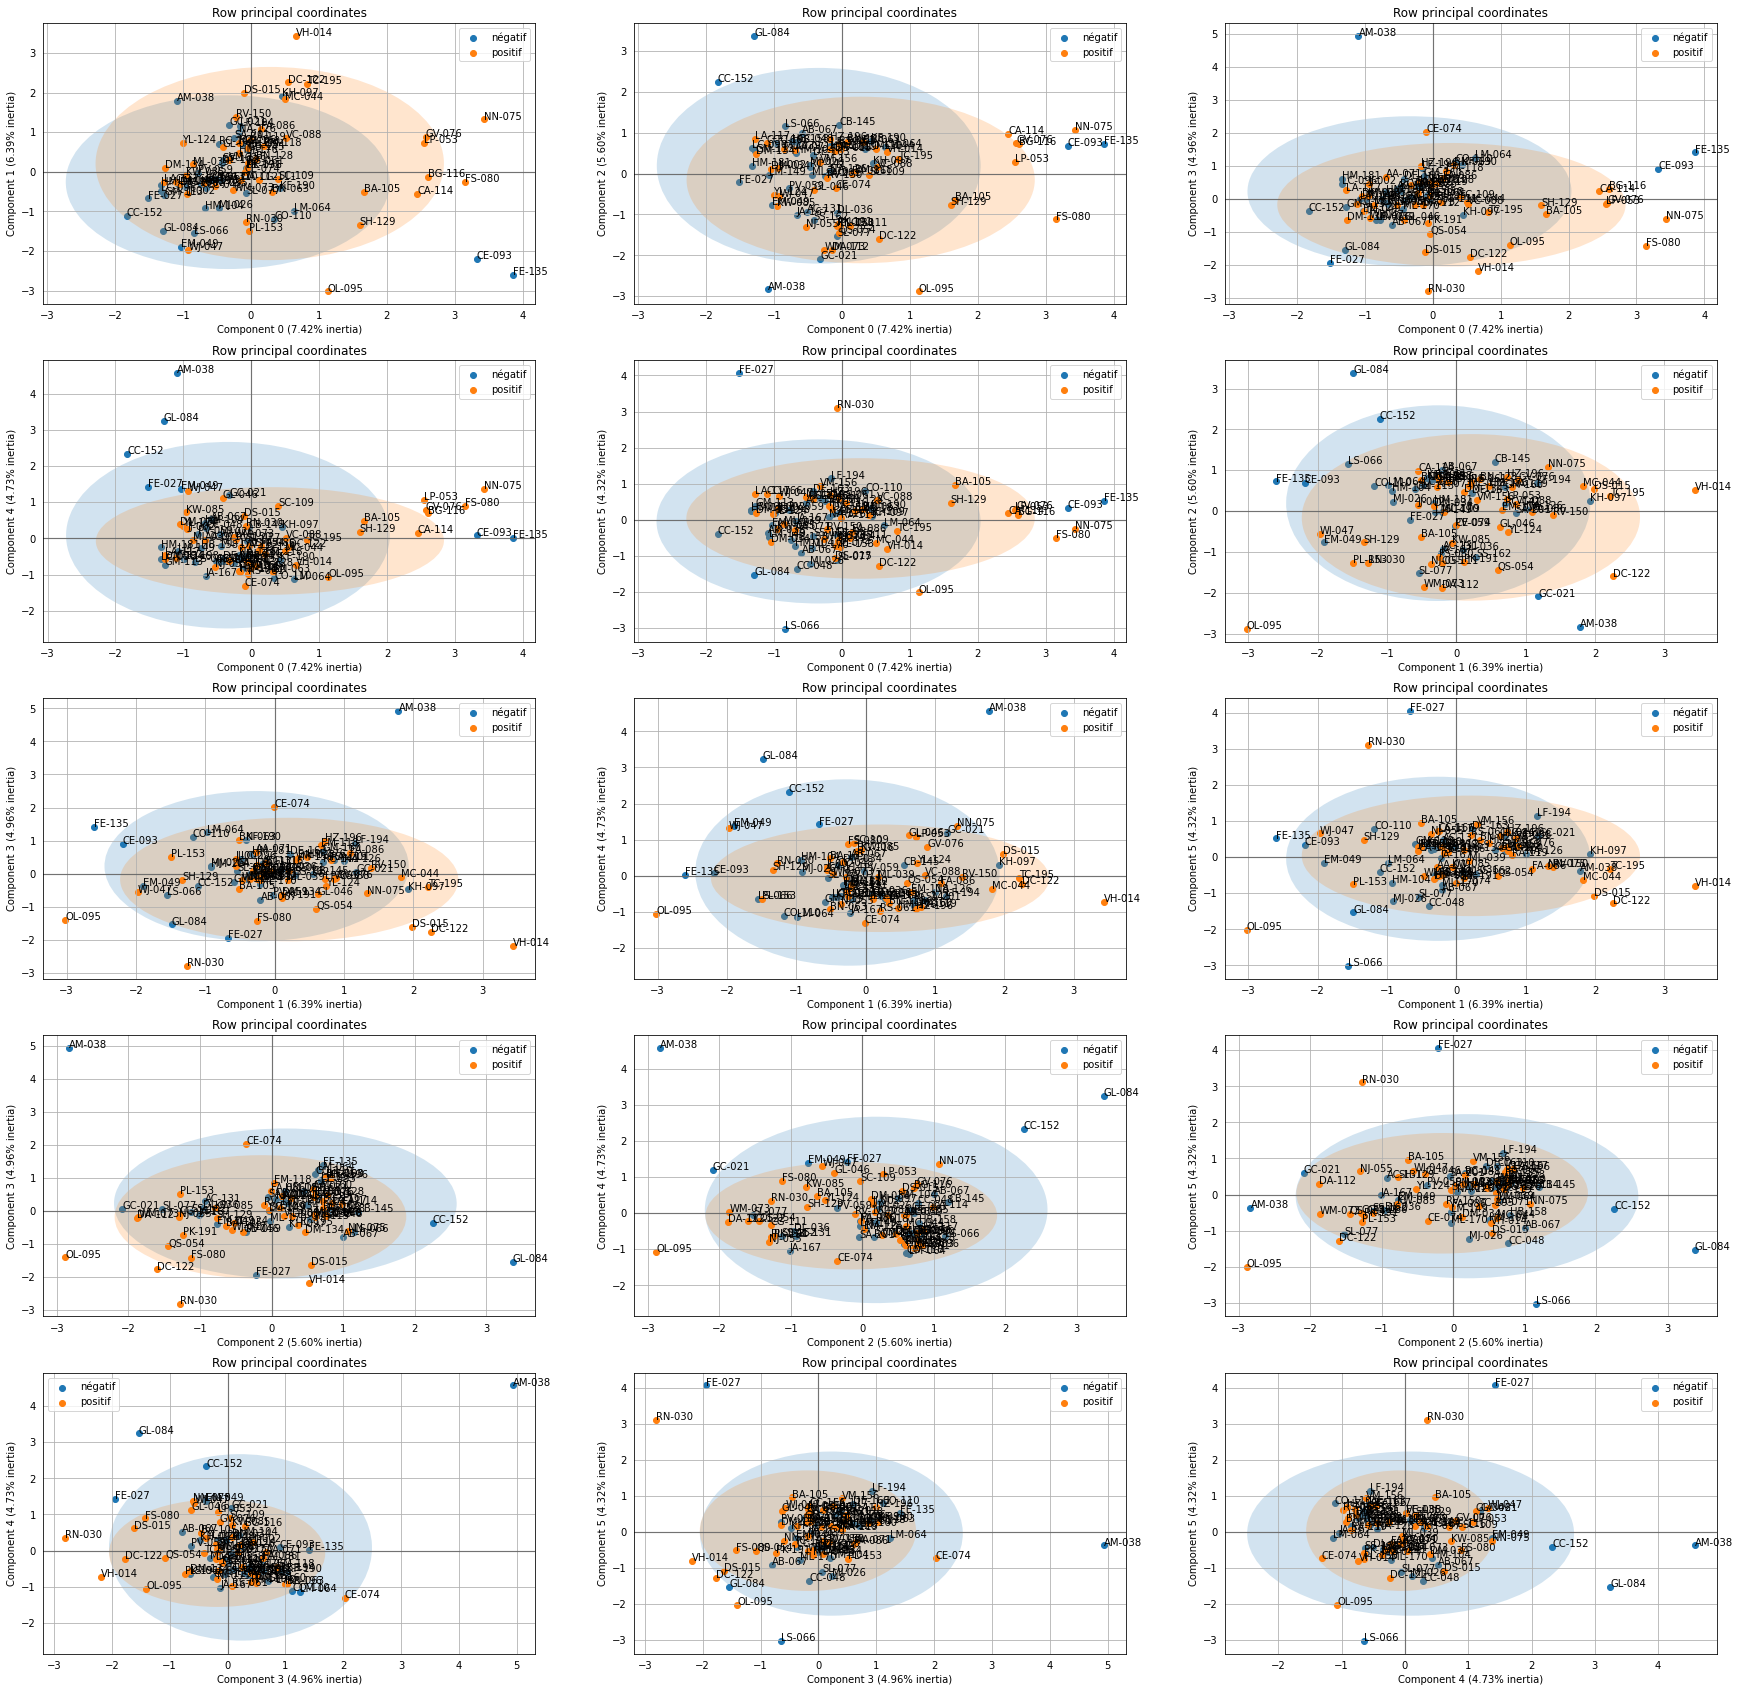

In [18]:
fig, ax = plt.subplots(5, 3, figsize=(30, 30))

# 1ere ligne : 
famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[0][0],
     # figsize=(10, 10),
     x_component=0,
     y_component=1,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[0][1],
     x_component=0,
     y_component=2,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[0][2],
     x_component=0,
     y_component=3,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[1][0],
     x_component=0,
     y_component=4,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)


famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[1][1],
     x_component=0,
     y_component=5,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[1][2],
     x_component=1,
     y_component=2,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[2][0],
     x_component=1,
     y_component=3,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[2][1],
     x_component=1,
     y_component=4,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[2][2],
     x_component=1,
     y_component=5,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[3][0],
     x_component=2,
     y_component=3,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[3][1],
     x_component=2,
     y_component=4,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[3][2],
     x_component=2,
     y_component=5,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[4][0],
     x_component=3,
     y_component=4,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[4][1],
     x_component=3,
     y_component=5,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_enc_2.plot_row_coordinates(
     features_enc,
     ax=ax[4][2],
     x_component=4,
     y_component=5,
     labels=features.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

plt.show()

In [19]:
famd_enc_2.row_coordinates(features_enc)

,0,1,2,3,4,5
Numéro anonymat,,,,,,
JJ-002,-0.940707,-0.560205,0.142690,0.444000,0.250900,0.284843
VH-014,0.665926,3.436231,0.523108,-2.183088,-0.734987,-0.801276
DS-015,-0.106885,1.984231,0.549278,-1.624347,0.612749,-1.068874
GC-021,-0.320299,1.179199,-2.088762,0.062185,1.191516,0.591540
MJ-026,-0.466620,-0.913755,0.214904,0.235046,0.110221,-1.226470
...,...,...,...,...,...,...
LF-194,-0.160425,1.156331,0.694946,0.931086,-0.557335,1.144181
TC-195,0.819402,2.218098,0.364280,-0.410867,-0.057263,-0.319425
HZ-196,-0.170224,0.730719,0.836401,0.991729,-0.921767,0.700155


In [20]:
famd_enc_2.column_correlations(features_enc).apply(lambda x: np.abs(x)).sort_values(0, ascending=False)

,0,1,2,3,4,5
sf.dsp.type_0,0.831085,0.140142,0.133274,0.088446,0.272145,0.020022
sf.dsp,0.831085,0.140142,0.133274,0.088446,0.272145,0.020022
sf.dsp.eva,0.784070,0.264822,0.180226,0.216985,0.247693,0.096123
sf.dsp.type_profonde,0.490279,0.423837,0.139026,0.155693,0.223562,0.018545
tv.douloureux,0.465199,0.162110,0.373756,0.121661,0.072611,0.079922
...,...,...,...,...,...,...
atcd.fibrome,0.023473,0.132723,0.151794,0.116050,0.067537,0.005172
sf.dsm,0.020759,0.060214,0.190174,0.282279,0.345110,0.163371
ttt.p1,0.009945,0.071048,0.306096,0.120136,0.194406,0.065938
chir_RW,0.009631,0.022329,0.033259,0.173306,0.069787,0.073909


In [21]:
famd_ONE_2 = prince.FAMD(
     n_components=6,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42)

In [22]:
famd_ONE_2.fit(features_ONE_enc)

FAMD(n_components=6, n_iter=10, random_state=42)

In [23]:
famd_ONE_2.row_coordinates(features_ONE_enc)

,0,1,2,3,4,5
Numéro anonymat,,,,,,
JJ-002,1.491176,-0.490252,-0.228295,-0.852418,1.055659,-0.013576
VH-014,-0.104108,0.157952,-0.230512,1.926910,-1.025902,1.578742
DS-015,1.657475,-0.536617,-0.444975,1.216846,-0.712279,0.963803
GC-021,0.294090,-1.808859,1.730357,0.035326,-0.792859,-0.804435
MJ-026,-0.572069,0.417187,-0.030271,0.253075,0.183564,-0.237128
...,...,...,...,...,...,...
LF-194,-1.270250,-0.937168,0.416321,-0.507204,0.073669,0.879781
TC-195,0.896485,-0.033449,0.394271,0.936155,-0.438343,0.859153
HZ-196,-1.295588,-0.540273,0.826016,-0.834258,-0.232893,0.651090


In [24]:
df_famd_2_col_corr = famd_ONE_2.column_correlations(features_ONE_enc)

In [25]:
df_famd_2_col_corr.apply(lambda x: np.abs(x)).sort_values(0, ascending=False)

,0,1,2,3,4,5
p,0.902320,0.119729,0.025932,0.349985,0.264028,0.184471
g,0.840357,0.321028,0.121394,0.377199,0.354414,0.116298
age,0.775669,0.130935,0.100434,0.222322,0.190813,0.595389
atcd.endo_negatif,0.410699,0.043528,0.018506,0.251145,0.166960,0.345507
atcd.endo_positif,0.410699,0.043528,0.018506,0.251145,0.166960,0.345507
...,...,...,...,...,...,...
chir_CAP_negatif,0.010258,0.048565,0.085718,0.236279,0.055566,0.405275
echo.oma_negatif,0.004127,0.063080,0.021853,0.036708,0.092529,0.283900
echo.oma_positif,0.004127,0.063080,0.021853,0.036708,0.092529,0.283900
atcd.sma.douleur_positif,0.000436,0.183904,0.112703,0.031339,0.040945,0.091693


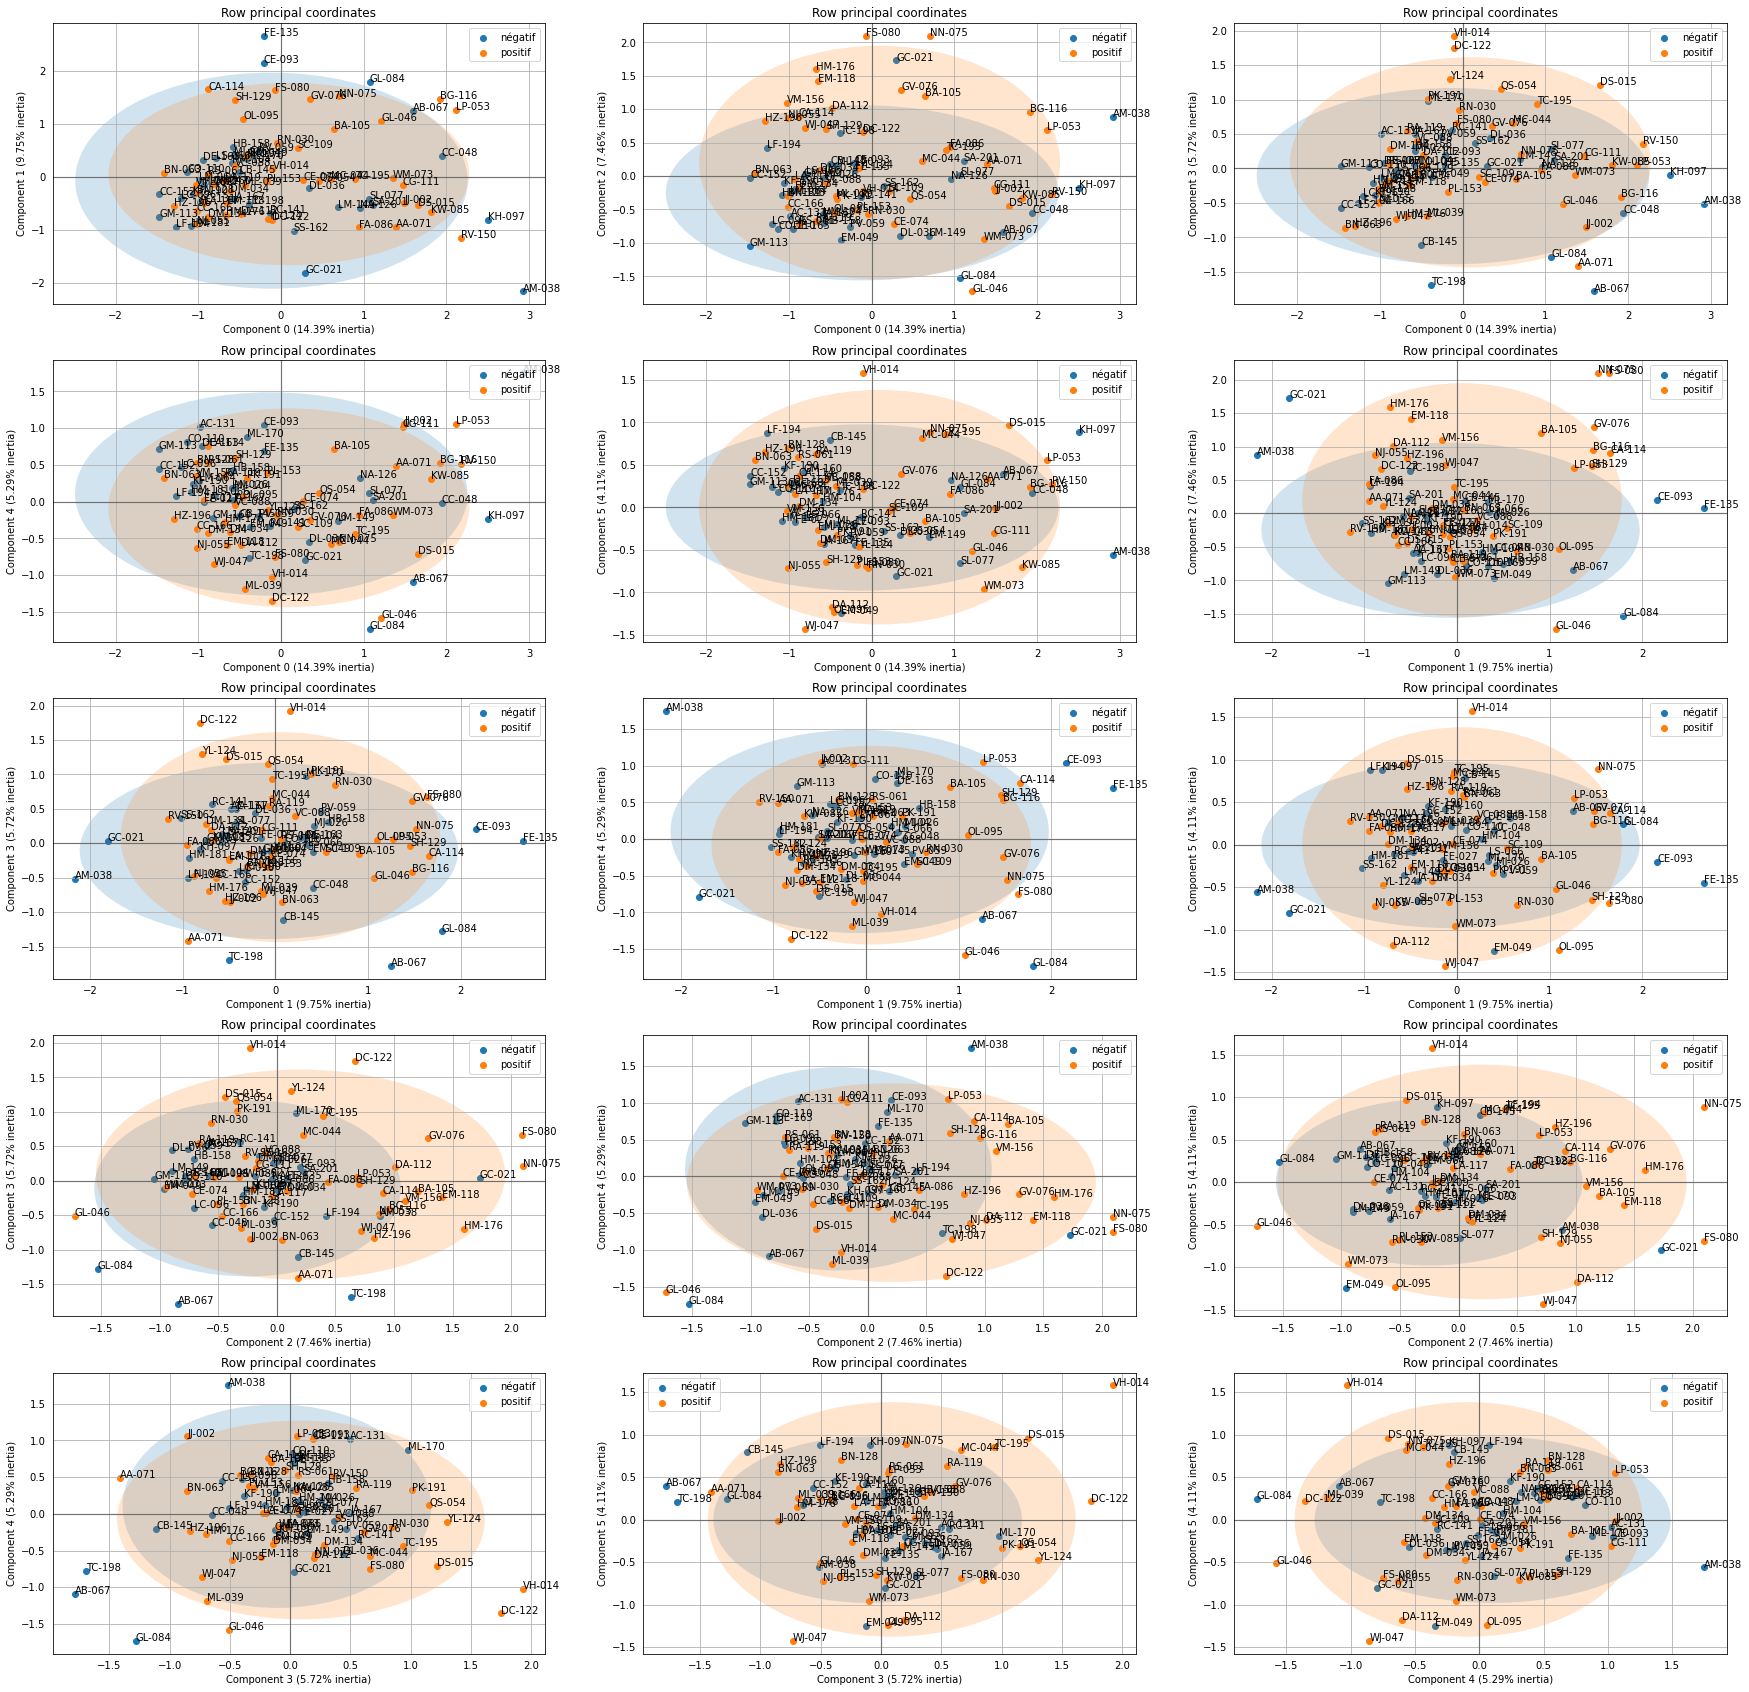

In [26]:
fig2, ax2 = plt.subplots(5, 3, figsize=(30, 30))

# 1ere ligne : 
famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[0][0],
     # figsize=(10, 10),
     x_component=0,
     y_component=1,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[0][1],
     x_component=0,
     y_component=2,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[0][2],
     x_component=0,
     y_component=3,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[1][0],
     x_component=0,
     y_component=4,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)


famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[1][1],
     x_component=0,
     y_component=5,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[1][2],
     x_component=1,
     y_component=2,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[2][0],
     x_component=1,
     y_component=3,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[2][1],
     x_component=1,
     y_component=4,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[2][2],
     x_component=1,
     y_component=5,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[3][0],
     x_component=2,
     y_component=3,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[3][1],
     x_component=2,
     y_component=4,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[3][2],
     x_component=2,
     y_component=5,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[4][0],
     x_component=3,
     y_component=4,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[4][1],
     x_component=3,
     y_component=5,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

famd_ONE_2.plot_row_coordinates(
     features_ONE_enc,
     ax=ax2[4][2],
     x_component=4,
     y_component=5,
     labels=features_ONE_enc.index,
     color_labels = list(endometriose),
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

plt.show()